In [1]:
!pip install yt-dlp spleeter -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
beatrix-jupyterlab 2023.814.150030 requires jupyter-server~=1.16, but you have jupyter-server 2.12.1 which is incompatible.
beatrix-jupyterlab 2023.814.150030 requires jupyterlab~=3.4, but you have jupyterlab 4.0.5 which is incompatible.
cudf 23.8.0 requires protobuf<5,>=4.21, but you have protobuf 3.19.6 which is incompatible.
cuml 23.8.0 requires dask==2023.7.1, but you have dask 2023.12.0 which is incompatible.
c

In [2]:
# External libraries
import os
import re
import subprocess
import contextlib
import logging
from functools import wraps
from pathlib import Path

# Data manipulation and analysis
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# Machine learning and data processing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt

# Audio processing and analysis
import librosa
import yt_dlp
from spleeter.separator import Separator
import ffmpeg
import torchaudio

# Deep learning
import torch
from transformers import AutoModelForAudioClassification, ASTFeatureExtractor

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def suppress_output(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        # Redirect stdout and logging to os.devnull
        with open(os.devnull, 'w') as fnull:
            with contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
                # Configure logging to use a NullHandler
                null_handler = logging.NullHandler()
                root_logger = logging.getLogger()
                original_handlers = root_logger.handlers.copy()
                root_logger.handlers = [null_handler]
                try:
                    result = func(*args, **kwargs)
                finally:
                    # Restore the original logging handlers
                    root_logger.handlers = original_handlers
        return result
    return wrapper

In [42]:
#@suppress_output
def download_youtube_audio(url):
    ydl_opts = {
        'format': 'ba',
        'format_sort': ['+size'],
        'outtmpl': '%(id)s.%(ext)s',
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'wav',  
        }]
    }

    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])
        video_info = ydl.extract_info(url, download=False)
    
    video_path_local = Path(f"{video_info['id']}.wav")
    
    return video_path_local

In [5]:
@suppress_output
def slice_wav_by_length(input_file, outfile_name_pattern, desired_length=600):
    # FFmpeg command to split the WAV file into 10-minute segments
    command = [
        'ffmpeg',
        '-hide_banner',  # Added to hide FFmpeg banner
        '-loglevel', 'error',  # Set log level to error
        '-i', input_file,
        '-f', 'segment',
        '-segment_time', str(desired_length),
        '-c', 'copy',
        f"{outfile_name_pattern}%03d.wav"
    ]

    # Run the FFmpeg command
    subprocess.run(command)

In [6]:
#@suppress_output
def seperate_vocal_and_accompanies(separator, output_paths):
    output_directory = 'output'
    os.makedirs(output_directory, exist_ok=True)
    
    for file_path in tqdm(output_paths, desc="Processing files"):
        output_file_path = os.path.join(output_directory, os.path.basename(file_path))
        separator.separate_to_file(file_path, output_file_path)

In [7]:
def get_filepaths_with_string_and_extension(
    root_directory='.', target_string='', extension=''):
    return sorted([os.path.abspath(os.path.join(root, file)) 
         for root, _, files in os.walk(root_directory)
         for file in files 
         if target_string in file and (not extension or file.endswith(extension))]
    )

In [8]:
def load_and_slice_audio(vocal_paths, slice_duration=10):
    all_samples = []
    all_sampling_rates = []

    for path in tqdm(vocal_paths):
        waveform, sampling_rate = torchaudio.load(path)
        waveform = waveform.squeeze().numpy()

        num_slices = waveform.shape[-1] // (sampling_rate * slice_duration)

        samples = [
            #torch.from_numpy(
            
                waveform[:, i * sampling_rate * slice_duration : (i + 1) * sampling_rate * slice_duration]
            #)
            for i in range(num_slices)
        ]

        all_samples.extend(samples)
        all_sampling_rates.extend([sampling_rate] * num_slices)

    return all_samples, all_sampling_rates

In [9]:
def get_common_sampling_rate(sampling_rates):
    if len(set(sampling_rates)) == 1:
        return int(sampling_rates[0])
    else:
        raise ValueError("All sampling rates should be the same.")

In [10]:
def predict_samples(model, feature_extractor, monofied_samples, sampling_rate, device):
    result = []
    raw_outputs = []

    for i, sample in tqdm(enumerate(monofied_samples), total=len(monofied_samples), desc="Processing samples"):
        inputs = feature_extractor(
            sample, feature_size=2, sampling_rate=sampling_rate, 
            padding="max_length", return_tensors="pt"
        )
        
        input_values = inputs.input_values.to(device)

        with torch.no_grad():
            outputs = model(input_values)
            predicted_labels = model.config.id2label[outputs.logits.argmax(-1).item()]
            result.append([i, predicted_labels])
            raw_outputs.append(outputs)

    return result, raw_outputs

In [11]:
def create_dataframe(predictions, time_window_length):
    df = pd.DataFrame(predictions, columns=['index', 'class'])
    df['start'] = df['index'].apply(lambda x: seconds_to_hhmmss(x*time_window_length))
    df['end'] = df['index'].apply(lambda x: seconds_to_hhmmss((x+1)*time_window_length))
    return df

In [12]:
def audio_analyzer(file_paths, model, device, slice_duration, normalize=True):
    sliced_samples, sampling_rates = load_and_slice_audio(file_paths, slice_duration)
    #monofied_samples = [torch.mean(x, dim=0) for x in sliced_samples]
    mono_array = np.mean(np.array(sliced_samples), axis=1)
    sampling_rate = get_common_sampling_rate(sampling_rates)

    feature_extractor = ASTFeatureExtractor(
        sampling_rate=sampling_rate, do_normalize=normalize
    )

    predictions, raw_outputs = predict_samples(
        model, feature_extractor, mono_array, sampling_rate, device
    )

    result_df = create_dataframe(predictions, time_window_length=slice_duration)

    return result_df, raw_outputs

In [13]:
def class_manipulator_old(input_df):
    # Create a copy of the input DataFrame to avoid modifying the original
    df = input_df.copy()

    # Binarize the 'class' column
    df['binarized_class'] = df['class'].apply(
        lambda x: 0 if (x in ['Speech','Tick', 'Clicking', ]) else 1
    )

    # Create the 'group' column
    df['group'] = (df['binarized_class'] != df['binarized_class'].shift()).cumsum()

    # Group the DataFrame by the new 'group' column
    grouped_df = df.groupby(['binarized_class', 'group']).agg(
        start=('start', 'first'),
        end=('end', 'last'),
        class_value=('class', 'first')
    ).reset_index(drop=True)

    # Filter out unwanted classes and sort by 'start'
    intermediate_df = grouped_df[
        ~grouped_df['class_value'].isin(['Speech','Tick', 'Clicking',])
    ].sort_values('start').reset_index(drop=True)

    return intermediate_df

In [14]:
def class_manipulator(input_df, singing_like_classes):
    
    def _get_most_frequent_with_fallback(x):
        modes = x.mode()
        if not modes.empty:
            if any(mode in singing_like_classes for mode in modes):
                return 'Singing'
        return None #'Speech'
    
    # Create a copy of the input DataFrame to avoid modifying the original
    df = input_df.copy()
    
    # Binarize the 'class' column
    df['binarized_class'] = df['class'].apply(
        lambda x : 1 if (x in singing_like_classes) else 0
    )

    # Create the 'group' column
    df['group'] = (df['binarized_class'] != df['binarized_class'].shift()).cumsum()

    # Group the DataFrame by the new 'group' column
    grouped_df = df.groupby(['binarized_class', 'group']).agg(
        start=('start', 'first'),
        end=('end', 'last'),
        class_value=('class', _get_most_frequent_with_fallback) 
    ).reset_index(drop=True).dropna()

    return grouped_df.reset_index(drop=True)

In [15]:
def group_same_songs(input_df, interval_threshold, duration_threshold):
    
    df = input_df.copy()

    df['start'] = pd.to_datetime(df['start'])
    df['end'] = pd.to_datetime(df['end'])

    df['group'] = 0

    for i in range(1, len(df)):
        if (df['start'][i] - df['end'][i - 1]).total_seconds() <= interval_threshold:
            df.at[i, 'group'] = df.at[i - 1, 'group']
        else:
            df.at[i, 'group'] = df.at[i - 1, 'group'] + 1

    grouped_df = df.groupby('group')

    for group, group_df in grouped_df:
        duration = (group_df['end'].max() - group_df['start'].min()).total_seconds()
        if duration < duration_threshold:
            df = df[df['group'] != group]

    df = df.drop(columns=['class_value'])

    df = df.groupby('group').agg({'start':'first', 'end':'last'})

    df['start'] = df['start'].apply(lambda x:x.strftime('%H:%M:%S'))
    df['end'] = df['end'].apply(lambda x:x.strftime('%H:%M:%S'))
    
    return df.reset_index(drop=True)

In [16]:
def mfcc_from_accompanies(accompanies_paths, slice_duration=5):

    sliced_samples, sampling_rates = load_and_slice_audio(accompanies_paths, slice_duration)
    #monofied_samples = [torch.mean(x, dim=0) for x in sliced_samples]
    mono_array = np.mean(np.array(sliced_samples), axis=1)
    
    sampling_rate = get_common_sampling_rate(sampling_rates)
    mfccs = [librosa.feature.mfcc(y=y, sr=sampling_rate, n_mfcc=13) 
             for y in mono_array]
    
    return mfccs

In [17]:
def cluster_mfccs(mfccs):
    full_flattens = [x.flatten() for x in mfccs]
    kmeans = KMeans(n_clusters=2, n_init=2)  # You can choose the number of clusters
    kmeans.fit(full_flattens)
    cluster_labels = kmeans.labels_

    indices = np.arange(len(cluster_labels))
    temp_df = create_dataframe(np.vstack((indices, cluster_labels)).T, time_window_length=5)

    value_counts = temp_df['class'].value_counts()
    major_value = value_counts.idxmax()
    minor_value = value_counts.idxmin()

    label_mapping = {major_value: 'Speech', minor_value: 'Singing'}
    temp_df['class_value'] = temp_df['class'].map(label_mapping)

    return temp_df[temp_df['class_value']=='Singing'].reset_index(drop=True)

In [18]:
def calculate_rms_energy(mfcc):
    return np.sqrt(np.mean(np.square(mfcc), axis=1))

def visualize_energy_over_time(mfccs, cluster_labels):
    # Calculate RMS energy for each MFCC
    energies = np.array([calculate_rms_energy(mfcc) for mfcc in mfccs])
    
    # Concatenate all energy arrays into a single array
    all_energies = np.concatenate(energies)
    
    # Create a corresponding time axis
    time_axis = np.arange(all_energies.size)
    
    # Plot the energy levels over time
    plt.figure(figsize=(14, 6))
    plt.plot(time_axis, all_energies, alpha=0.5)
    plt.xlabel('Time')
    plt.ylabel('Energy Level (RMS)')
    plt.title('Energy Level of Each Fragment Over Time')
    plt.show()

def cluster_mfccs_with_pca(mfccs, visualize=False):
    # Flatten the MFCCs
    full_flattens = [x.flatten() for x in mfccs]

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(full_flattens)

    # Perform KMeans clustering on the reduced data
    kmeans = KMeans(n_clusters=2, init='k-means++', n_init=2)  
    kmeans.fit(reduced_data)
    cluster_labels = kmeans.labels_

    if visualize:  # Visualization of clusters
        plt.scatter(reduced_data[:, 0], reduced_data[:, 1], 
                    c=cluster_labels, cmap='viridis', alpha=0.5)
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.title('Clustering of MFCCs with PCA')
        plt.colorbar(label='Cluster')
        plt.show()
        
        # Visualization of energy levels over time
        visualize_energy_over_time(mfccs, cluster_labels)

    # Calculate RMS energy for each cluster
    cluster_energy = {label: [] for label in set(cluster_labels)}
    for label, mfcc in zip(cluster_labels, mfccs):
        cluster_energy[label].append(calculate_rms_energy(mfcc))

    # Determine which cluster has higher mean RMS energy
    singing_label = max(cluster_energy, key=lambda label: np.mean(cluster_energy[label]))
    non_singing_label = min(cluster_energy, key=lambda label: np.mean(cluster_energy[label]))

    # Map the labels to 'Singing' and 'Non-Singing'
    label_mapping = {singing_label: 'Singing', non_singing_label: 'Non-Singing'}
    temp_df = create_dataframe(np.vstack((np.arange(len(cluster_labels)), cluster_labels)).T, time_window_length=5)
    temp_df['class_value'] = temp_df['class'].map(label_mapping)

    # Separate the dataframes
    singing_df = temp_df[temp_df['class_value'] == 'Singing'].reset_index(drop=True)
    non_singing_df = temp_df[temp_df['class_value'] != 'Singing'].reset_index(drop=True)

    return singing_df, non_singing_df


In [19]:
from scipy.fftpack import dct

def calculate_spectral_energy(mfcc):
    # Apply Discrete Cosine Transform to get the spectral energy
    spectral_energy = dct(mfcc, type=2, n=mfcc.shape[0], axis=-1, norm='ortho')
    return np.sum(spectral_energy**2)

def cluster_mfccs_with_spectral_energy(mfccs, visualize=False):
    # Flatten the MFCCs
    full_flattens = [x.flatten() for x in mfccs]

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(full_flattens)

    # Perform KMeans clustering on the reduced data
    kmeans = KMeans(n_clusters=2, init='k-means++', n_init=2)  
    kmeans.fit(reduced_data)
    cluster_labels = kmeans.labels_

    # Calculate Spectral Energy for each cluster
    cluster_energy = {label: [] for label in set(cluster_labels)}
    for label, mfcc in zip(cluster_labels, mfccs):
        cluster_energy[label].append(calculate_spectral_energy(mfcc))

    # Determine which cluster has higher mean Spectral Energy
    complex_label = max(cluster_energy, key=lambda label: np.mean(cluster_energy[label]))
    simple_label = min(cluster_energy, key=lambda label: np.mean(cluster_energy[label]))

    # Map the labels to 'Complex' and 'Simple'
    label_mapping = {complex_label: 'Complex', simple_label: 'Simple'}
    temp_df = create_dataframe(np.vstack((np.arange(len(cluster_labels)), cluster_labels)).T, time_window_length=5)
    temp_df['class_value'] = temp_df['class'].map(label_mapping)

    # Separate the dataframes
    complex_df = temp_df[temp_df['class_value'] == 'Complex'].reset_index(drop=True)
    simple_df = temp_df[temp_df['class_value'] != 'Complex'].reset_index(drop=True)

    return complex_df, simple_df


In [20]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import numpy as np

def compare_clustering_quality(mfccs, n_clusters=2):
    # Without PCA
    kmeans_no_pca = KMeans(n_clusters=n_clusters, n_init=2)
    kmeans_no_pca.fit(np.vstack([x.flatten() for x in mfccs]))
    cluster_labels_no_pca = kmeans_no_pca.labels_
    inertia_no_pca = kmeans_no_pca.inertia_
    silhouette_score_no_pca = silhouette_score(np.vstack([x.flatten() for x in mfccs]), cluster_labels_no_pca)

    # With PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(np.vstack([x.flatten() for x in mfccs]))

    kmeans_with_pca = KMeans(n_clusters=n_clusters, n_init=2)
    kmeans_with_pca.fit(reduced_data)
    cluster_labels_with_pca = kmeans_with_pca.labels_
    inertia_with_pca = kmeans_with_pca.inertia_
    silhouette_score_with_pca = silhouette_score(reduced_data, cluster_labels_with_pca)

    # Print results
    print("Clustering Quality Comparison:")
    print("Without PCA:")
    print(f"Inertia: {inertia_no_pca}") #sum of squared distance to center of each sample
    print(f"Silhouette Score: {silhouette_score_no_pca}") 
    # [b] - [a] over
    # max(mean distance for a sample to its other samples in same cluster [a] or not [b])
    print("With PCA:")
    print(f"Inertia: {inertia_with_pca}")
    print(f"Silhouette Score: {silhouette_score_with_pca}")

    return (inertia_no_pca, silhouette_score_no_pca), (inertia_with_pca, silhouette_score_with_pca)

In [21]:
def seconds_to_hhmmss(total_seconds):
    m, s = divmod(total_seconds, 60)
    h, m = divmod(m, 60)
    return f"{h:02d}:{m:02d}:{s:02d}"
        
def hhmmss_to_seconds(hms):
    h, m, s = map(int, hms.split(':'))
    return h * 3600 + m * 60 + s

In [22]:
def check_overlap(interval1_start, interval1_end, interval2_start, interval2_end):
    return (interval1_start <= interval2_end and interval1_end >= interval2_start) or \
           (interval2_start <= interval1_end and interval2_end >= interval1_start)

def filter_redundant_overlaps(unique_overlapping_timestamps):
    filtered_overlapping_timestamps = [
        overlap for overlap in unique_overlapping_timestamps
        if all(
            not (
                (overlap['start']) >= (other_overlap['start']) and
                (overlap['end']) <= (other_overlap['end'])
            )
            for other_overlap in unique_overlapping_timestamps
            if overlap != other_overlap
        )
    ]
    return filtered_overlapping_timestamps

def merge_overlapping_times_df(df):
    # Sort the DataFrame by start time
    df_sorted = df.sort_values(by=['start'])

    merged_times = []

    # Initialize variables to keep track of the current start and end times
    current_start = df_sorted.iloc[0]['start']
    current_end = df_sorted.iloc[0]['end']

    # Iterate over the sorted DataFrame
    for index, row in df_sorted.iloc[1:].iterrows():
        start = row['start']
        end = row['end']
        
        # Check for overlap
        if start <= current_end:
            # Update the current end time if necessary
            current_end = max(current_end, end)
        else:
            # Add the merged time interval to the list and update current start and end times
            merged_times.append({'start': current_start, 'end': current_end})
            current_start = start
            current_end = end

    # Add the last merged time interval
    merged_times.append({'start': current_start, 'end': current_end})
    result = pd.DataFrame(merged_times)
    return result

def find_and_filter_overlapping_timestamps(accompanies_df, vocal_df, threshold=0):
        
    unique_overlapping_timestamps = []

    for _, row1 in accompanies_df.iterrows():
        for _, row2 in vocal_df.iterrows():
            start1_seconds = hhmmss_to_seconds(row1['start'])
            end1_seconds = hhmmss_to_seconds(row1['end'])
            start2_seconds = hhmmss_to_seconds(row2['start'])
            end2_seconds = hhmmss_to_seconds(row2['end'])

            # Check for overlap
            if check_overlap(start1_seconds, end1_seconds, start2_seconds, end2_seconds):
                overlap_start = min(start1_seconds, start2_seconds)
                overlap_end = max(end1_seconds, end2_seconds)
                overlapping_timestamp = {
                    'start': overlap_start,#seconds_to_hhmmss(overlap_start),
                    'end': overlap_end#seconds_to_hhmmss(overlap_end)
                }
                if overlapping_timestamp not in unique_overlapping_timestamps:
                    unique_overlapping_timestamps.append(overlapping_timestamp)

    filtered_overlapping_timestamps = filter_redundant_overlaps(
        unique_overlapping_timestamps
    )

    merged_result = pd.DataFrame(filtered_overlapping_timestamps)

    result = merge_overlapping_times_df(merged_result)
    result['SameGroupPossibility'] = (
        result['start'].shift(-1) - result['end']) < threshold

    result['TooLong'] = result['end'] - result['start'] > 420
    result['SameGroupPossibility'].fillna(False, inplace=True)
    result['start'] = result['start'].apply(seconds_to_hhmmss)
    result['end'] = result['end'].apply(seconds_to_hhmmss)
    return result

In [43]:
!rm -rf ./output

output_filename_pattern = 'hssh'
root_dir = '.'  
youtube_url = 'https://www.youtube.com/watch?v=jRpr8bun3xE'

separator = Separator("spleeter:2stems")

slice_wav_by_length(download_youtube_audio(youtube_url), output_filename_pattern)

wav_slice_paths = get_filepaths_with_string_and_extension(
    root_dir, target_string = output_filename_pattern, extension='wav'
)

seperate_vocal_and_accompanies(separator, wav_slice_paths)

accompanies_paths = get_filepaths_with_string_and_extension(
    root_dir, target_string = 'accompaniment', extension='wav'
)

vocal_paths = get_filepaths_with_string_and_extension(
    root_dir, target_string = 'vocal', extension='wav'
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = AutoModelForAudioClassification.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593"
).to(device)

classes = model.config.id2label
singing_like_indices = [27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
                        112, 113, 114, 116, 117, 118, 119, 120, 136, 
                        254, 255, 266, 259, 268, 269, 271, 402, 496, 503,523, 526]
singing_like_classes = [classes.get(x) for x in singing_like_indices]

[youtube] Extracting URL: https://www.youtube.com/watch?v=jRpr8bun3xE
[youtube] jRpr8bun3xE: Downloading webpage
[youtube] jRpr8bun3xE: Downloading ios player API JSON
[youtube] jRpr8bun3xE: Downloading android player API JSON


[youtube] jRpr8bun3xE: Downloading MPD manifest
[info] jRpr8bun3xE: Downloading 1 format(s): 140
[dashsegments] Total fragments: 4068
[download] Destination: jRpr8bun3xE.m4a




ERROR: Did not get any data blocks


[download] fragment not found; Skipping fragment 882 ...
[download] 100% of  164.03MiB in 00:15:33 at 179.97KiB/s                    
[FixupM4a] Correcting container of "jRpr8bun3xE.m4a"
[FixupDuplicateMoov] Fixing duplicate MOOV atoms of "jRpr8bun3xE.m4a"
[ExtractAudio] Destination: jRpr8bun3xE.wav
Deleting original file jRpr8bun3xE.m4a (pass -k to keep)
[youtube] Extracting URL: https://www.youtube.com/watch?v=jRpr8bun3xE
[youtube] jRpr8bun3xE: Downloading webpage
[youtube] jRpr8bun3xE: Downloading ios player API JSON
[youtube] jRpr8bun3xE: Downloading android player API JSON


[youtube] jRpr8bun3xE: Downloading MPD manifest


Processing files:   0%|          | 0/14 [00:00<?, ?it/s]

INFO:spleeter:Downloading model archive https://github.com/deezer/spleeter/releases/download/v1.4.0/2stems.tar.gz
INFO:spleeter:Validating archive checksum
INFO:spleeter:Extracting downloaded 2stems archive
INFO:spleeter:2stems model file(s) extracted
INFO:spleeter:File output/hssh000.wav/hssh000/vocals.wav written succesfully
INFO:spleeter:File output/hssh000.wav/hssh000/accompaniment.wav written succesfully
INFO:spleeter:File output/hssh001.wav/hssh001/vocals.wav written succesfully
INFO:spleeter:File output/hssh001.wav/hssh001/accompaniment.wav written succesfully
INFO:spleeter:File output/hssh002.wav/hssh002/vocals.wav written succesfully
INFO:spleeter:File output/hssh002.wav/hssh002/accompaniment.wav written succesfully
INFO:spleeter:File output/hssh003.wav/hssh003/vocals.wav written succesfully
INFO:spleeter:File output/hssh003.wav/hssh003/accompaniment.wav written succesfully
INFO:spleeter:File output/hssh004.wav/hssh004/vocals.wav written succesfully
INFO:spleeter:File output/h

config.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [44]:
result_vocal, raw_outputs = audio_analyzer(
    vocal_paths, model, device, slice_duration=5
)

  0%|          | 0/14 [00:00<?, ?it/s]

Processing samples:   0%|          | 0/1624 [00:00<?, ?it/s]

In [45]:
vocal_result = group_same_songs(
    class_manipulator(result_vocal, singing_like_classes),
    interval_threshold=5, duration_threshold=10
)

In [46]:
mfccs = mfcc_from_accompanies(accompanies_paths, slice_duration=5)

  0%|          | 0/14 [00:00<?, ?it/s]

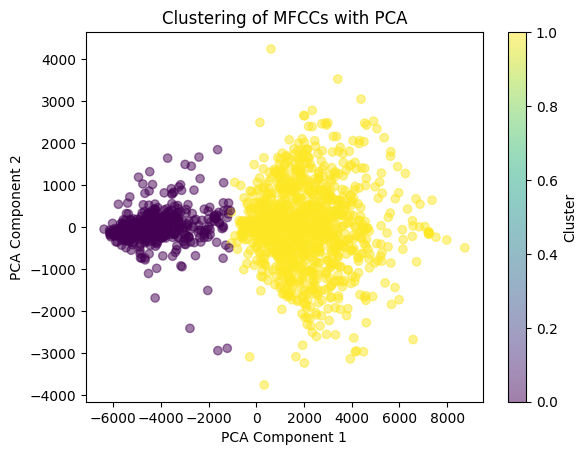

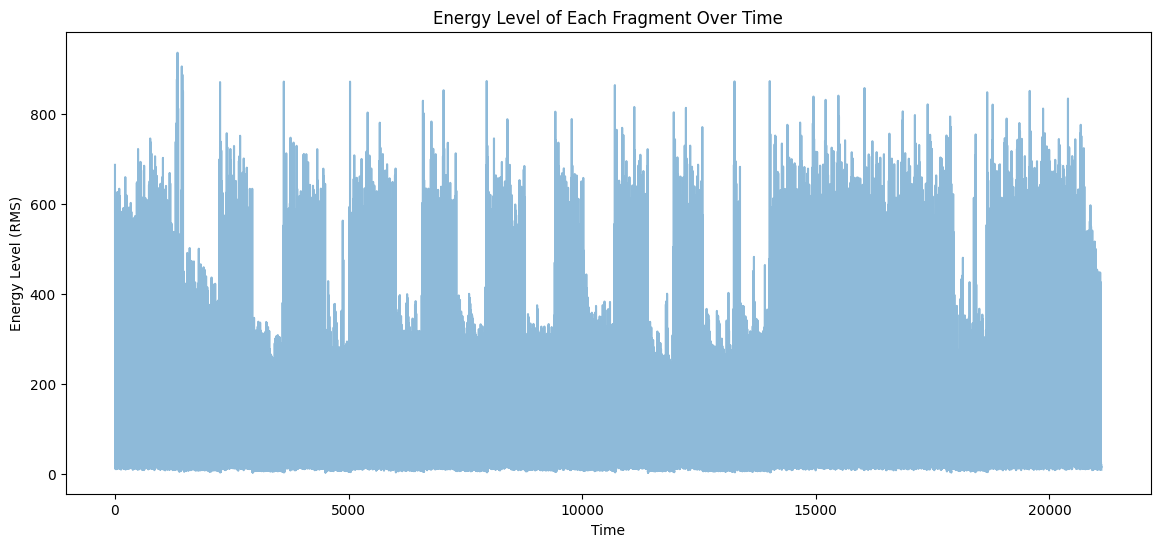

In [47]:
#cluster_mfccs_with_spectral_energy(mfccs)
_, accompanies_based_cluster= cluster_mfccs_with_pca(mfccs, visualize=True)
accompanies_result = group_same_songs(
    accompanies_based_cluster,
    interval_threshold=5, duration_threshold=10
)

In [48]:
higher_probability_timestamps = find_and_filter_overlapping_timestamps(
    accompanies_result, vocal_result, threshold=30
)

In [49]:
higher_probability_timestamps

,start,end,SameGroupPossibility,TooLong
0,00:09:25,00:14:20,False,False
1,00:18:55,00:23:05,False,False
2,00:28:55,00:32:10,False,False
3,00:38:35,00:42:10,False,False
4,00:46:55,00:50:55,False,False
5,00:56:20,01:00:25,False,False
6,01:04:20,01:08:30,False,False
7,01:13:10,01:16:35,False,False
8,01:20:45,01:24:55,False,False
9,01:25:50,01:29:50,False,False


In [50]:
print(higher_probability_timestamps.to_json())

{"start":{"0":"00:09:25","1":"00:18:55","2":"00:28:55","3":"00:38:35","4":"00:46:55","5":"00:56:20","6":"01:04:20","7":"01:13:10","8":"01:20:45","9":"01:25:50","10":"01:54:45","11":"01:58:10"},"end":{"0":"00:14:20","1":"00:23:05","2":"00:32:10","3":"00:42:10","4":"00:50:55","5":"01:00:25","6":"01:08:30","7":"01:16:35","8":"01:24:55","9":"01:29:50","10":"01:58:00","11":"01:59:35"},"SameGroupPossibility":{"0":false,"1":false,"2":false,"3":false,"4":false,"5":false,"6":false,"7":false,"8":false,"9":false,"10":true,"11":false},"TooLong":{"0":false,"1":false,"2":false,"3":false,"4":false,"5":false,"6":false,"7":false,"8":false,"9":false,"10":false,"11":false}}


In [51]:
def overlap(interval1, interval2):
    return not (interval1['end'] < interval2['start'] or interval1['start'] > interval2['end'])

non_overlapping_rows = []
for index, row in vocal_result.iterrows():
    interval = {'start': row['start'], 'end': row['end']}
    overlaps = False
    for _, hp_row in higher_probability_timestamps.iterrows():
        hp_interval = {'start': hp_row['start'], 'end': hp_row['end']}
        if overlap(interval, hp_interval):
            overlaps = True
            break
    if not overlaps:
        non_overlapping_rows.append(row)
        
possible_a_capella = pd.DataFrame(non_overlapping_rows).reset_index(drop=True)

print(possible_a_capella.to_json())

{"start":{"0":"00:00:00","1":"00:53:30"},"end":{"0":"00:00:15","1":"00:53:40"}}


In [52]:
possible_a_capella

,start,end
0,00:00:00,00:00:15
1,00:53:30,00:53:40


In [ ]:
raise

In [ ]:

aa = pd.Timestamp.now()

sliced_samples, sampling_rates = load_and_slice_audio(vocal_paths, slice_duration=5)
stereo_array = np.array(sliced_samples)
mono_array = np.mean(stereo_array, axis=1)

sampling_rate = get_common_sampling_rate(sampling_rates)

feature_extractor = ASTFeatureExtractor(
    sampling_rate=sampling_rate, do_normalize=True
)

features = feature_extractor(
    mono_array, feature_size=2, sampling_rate=sampling_rate, 
    padding="max_length", return_tensors="pt"
)

inputs = features.input_values.to(device)


batch_size = 16  # Define your batch size
result = []
raw_outputs = []

total_samples = inputs.shape[0]

with torch.no_grad():
    for i in range(0, total_samples, batch_size):
        batch_inputs = inputs[i:i+batch_size]  # Extract a batch of inputs
        outputs = model(batch_inputs)
        
        for seq_index in range(outputs.logits.shape[0]):
            predicted_labels = model.config.id2label[outputs.logits[seq_index].argmax(-1).item()]
            result.append([i+seq_index, predicted_labels])
        
        raw_outputs.append(outputs)

print(pd.Timestamp.now()-aa)


In [ ]:
raw_outputs